this script extracts transcription start sites of promoters from Molly's dataset

In [ ]:
##needs mysql installed
#Need to be aware that fasta file sequence can be multiline or single line, databases provide it multilined

In [2]:
from pybedtools import BedTool
from BCBio.GFF import GFFExaminer
from BCBio import GFF
import pprint
import pymysql.cursors
from pyfaidx import Fasta
import pandas as pd
import os
import numpy as np
import io

In [2]:
#examine the gff3 file
in_file = "/home/witham/Documents/Pipeline/data/TSS_data/AnnotatedPEATPeaks.txt"
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('Chr1',): 20692,
            ('Chr2',): 11967,
            ('Chr3',): 15930,
            ('Chr4',): 12159,
            ('Chr5',): 18540,
            ('ChrC',): 235,
            ('ChrM',): 183},
 'gff_source': {('MegrawPEAT',): 79706},
 'gff_source_type': {('MegrawPEAT', 'Peak'): 79706},
 'gff_type': {('Peak',): 79706}}


In [3]:
#examine the gff3 file
in_file = "/home/witham/Documents/Pipeline/data/genomes/Araport11_GFF3_genes_transposons.201606.gff"
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('Chr1',): 207497,
            ('Chr2',): 125500,
            ('Chr3',): 154731,
            ('Chr4',): 121971,
            ('Chr5',): 178800,
            ('ChrC',): 620,
            ('ChrM',): 771},
 'gff_source': {('Araport11',): 789890},
 'gff_source_type': {('Araport11', 'CDS'): 286355,
                     ('Araport11', 'antisense_RNA'): 91,
                     ('Araport11', 'antisense_lncRNA'): 1424,
                     ('Araport11', 'exon'): 200542,
                     ('Araport11', 'five_prime_UTR'): 46895,
                     ('Araport11', 'gene'): 33341,
                     ('Araport11', 'lnc_RNA'): 2455,
                     ('Araport11', 'mRNA'): 52270,
                     ('Araport11', 'miRNA'): 427,
                     ('Araport11', 'miRNA_primary_transcript'): 325,
                     ('Araport11', 'ncRNA'): 286,
                     ('Araport11', 'protein'): 48359,
                     ('Araport11', 'pseudogene'): 952,
                     ('Araport1

In [19]:
#examine the gff3 file
in_file = "../../data/genomes/Arabidopsis_thaliana/annotation/Arabidopsis_thaliana.TAIR10.47.gff3"
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('1',): 213207,
            ('2',): 122450,
            ('3',): 152568,
            ('4',): 121665,
            ('5',): 180531,
            ('Mt',): 615,
            ('Pt',): 528},
 'gff_source': {('The Arabidopsis Information Resource',): 7,
                ('araport11',): 791557},
 'gff_source_type': {('The Arabidopsis Information Resource', 'chromosome'): 7,
                     ('araport11', 'CDS'): 286067,
                     ('araport11', 'exon'): 313952,
                     ('araport11', 'five_prime_UTR'): 56384,
                     ('araport11', 'gene'): 27655,
                     ('araport11', 'lnc_RNA'): 3879,
                     ('araport11', 'mRNA'): 48359,
                     ('araport11', 'miRNA'): 325,
                     ('araport11', 'ncRNA'): 377,
                     ('araport11', 'ncRNA_gene'): 5178,
                     ('araport11', 'rRNA'): 15,
                     ('araport11', 'snRNA'): 82,
                     ('araport11', 'snoRNA'): 287,
 

In [4]:
# def download_chromosome_sizes(genome_assembly_id,output_file):
#     """download chromosome sizes from the UCSC Genome browser's mysql database, using the UCSC Genome Browser assembly ID"""
#     #connect to the database
#     connection = pymysql.connect(host='genome-euro-mysql.soe.ucsc.edu',
#                                 user='genome',
#                                 port=3306)
#     output = open(output_file, 'w') #make output file with write capability
#     try:
#         with connection.cursor() as cursor:
#             sql = f"SELECT 'chrom', 'size' FROM {genome_assembly_id}.chromInfo" #specify the columns and genome assembly
#             cursor.execute(sql) #grab the columns and genome assembly
#             result = cursor.fetchone()
#             output.write(result)
#     finally:
#         connection.close()
#     output.close()

In [3]:
def fasta_chromsizes(genome, output_file):
    """extracts chromosome sizes in a form compatible with BedTools.flank"""
    
    the_genome = Fasta(genome) #using pyfaidx Fasta, parse the genome file as a fasta
     
    chromsizes = {} #make dictionary called chromsizes
    for key in the_genome.keys():       
    
        chromsizes[f'{key}'] = f'({len(the_genome[key])})' #add the chromosome name and length to dictionary        
    #create empty string
    chromsizes_string = ''
    #iterate over chromsizes dictionary key/values. Add key, tab, value, newline to the string iteratively
    for k,v in chromsizes.items():
        chromsizes_string = chromsizes_string + f'{k}\t{v}\n'
    
    #write output file, deleting the parentheses created from the dictionary. This file is suitable for use in BedTools.flank
    with open(output_file, 'w') as output:            
        output.write(chromsizes_string.replace('(','').replace(')',''))

In [30]:
# def remove_overlapping_proms(promoter_bed,output_bed):
#     #read in promoters
#     proms_df = pd.read_table(promoter_bed, sep='\t', header=0)
#     cols = ['chr','start','stop','AGI','dot1','strand','source','type','dot2','attributes']
#     proms_df.columns = cols
#     #create bedtools object of promoters
#     proms_bed = BedTool(promoter_bed)
#     #c = columns to apply function to
#     #o = count number of merged promoters, name the first and last promoter that were merged
#     merged = proms_bed.merge(c=4, o=['count_distinct','first', 'last'])
#     #write to buffer
#     merged_buffer = io.StringIO()
#     merged_buffer.write(str(merged))
#     merged_buffer.seek(0)
#     #read as dataframe
#     overlapping = pd.read_table(merged_buffer, sep='\t', header=0)
#     cols2 = ['chr','start','stop', 'number_of_overlaps', 'first_overlap','second_overlap']
#     overlapping.columns = cols2
#     #select only features made of more than one promoter that were merged as overlapping
#     overlapping_only = overlapping[overlapping.number_of_overlaps >= 2]
    
#     #write to file before removing them
#    # overlapping_only.to_csv(output_bed,index=False,sep='\t',header=0)
# #     #remove overlapping promoters
# #     for i,data in proms_df.iterrows():
    
#     return overlapping_only

In [3]:
# def extract_genes(gene_gff,output_file):
#     """This function extracts all whole genes from a gff3 file, ignoring gene features, and adds them to an output file"""
#     stringToMatch = 'ID=gene'
#     matchedLine = ''
#     with open(gene_gff, 'r') as file:        
#         for line in file:
#             if stringToMatch in line:
#                 matchedLine = matchedLine + line + '\n'
    
    
#     with open(output_file, 'w') as output:
#         output.write(matchedLine)       
    

In [31]:
def extract_genes(gene_gff,output_overlapping,output_file):
    """This function extracts all whole genes from a gff3 file, ignoring gene features, and adds them to an output file. It also exports a file containing overlapping genes, and removes any overlapping genes from the final output"""
    #limit dictionary to genes
    limit_info = dict(gff_type = ['gene'])
    #open temporary buffer
    #output = open(temp, 'w')
    tempbuffer = io.StringIO()
    #open gff file, parse it, limiting to genes only. Save the file.
    with open(gene_gff, 'r') as in_handle:                    
            GFF.write(GFF.parse(in_handle, limit_info=limit_info),tempbuffer)
    
    #go back to beginning of the buffer
    tempbuffer.seek(0)
    
    #now remove the unwanted annotations that were added by GFF.write eg. Chr1	annotation	remark	1	30425192	.	.	.	gff-version=3
    #remove lines beginning with ##
    with open(output_file, 'w') as newfile:        
        for line in tempbuffer:
            line = line.strip() # removes hidden characters/spaces
            if line[0] == "#":
                pass
            else:                
                #don't include lines beginning with ##
                newfile.write(line + '\n') #output to new file
    #remove temporary buffer
    tempbuffer.close()       
    #read in gff file
    genes = pd.read_table(output_file, sep='\t', header=None)
    cols2 = ['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']
    genes.columns = cols2
    #remove all lines where source is annotation
    no_annotation = genes[~genes.source.str.contains("annotation")]
    #remove all lines that are not protein coding
    
    protein_coding = no_annotation[no_annotation.attributes.str.contains('biotype=protein_coding')]
    #add AGI column
    gene_agi = protein_coding.assign(AGI=protein_coding.attributes.str.extract(r'ID=gene:(.*?)\;'))
    #remove all features which overlap:
    #make buffer of genes
    genes_buffer = io.StringIO()
    gene_agi.to_csv(genes_buffer,index=False,sep='\t',header=None)
    genes_buffer.seek(0)
    #create bedtools object of genes
    genes_bed = BedTool(genes_buffer)
    #c = columns to apply function to
    #o = count number of merged promoters, name the first and last promoter that were merged
    merged = genes_bed.merge(c=10, o=['count_distinct','first', 'last'])
    #write to bufer
    merged_buffer = io.StringIO()
    merged_buffer.write(str(merged))
    merged_buffer.seek(0)
    #read as dataframe
    overlapping = pd.read_table(merged_buffer, sep='\t', header=None)
    
    cols3 = ['chr','start','stop', 'number_of_overlaps', 'first_overlap','second_overlap']
    overlapping.columns = cols3
    #select only features made of more than one promoter that were merged as overlapping
    overlapping_only = overlapping[overlapping.number_of_overlaps >= 2]
    #save these overlapping genes to file
    overlapping_only.to_csv(output_overlapping,index=False,sep='\t',header=None)
    #keep only non-overlapping genes
    final_genes_list = overlapping[overlapping.number_of_overlaps == 1]
    final_genes = gene_agi[gene_agi.AGI.isin(final_genes_list.first_overlap)]
    final_genes_noAGI = final_genes[cols2]
    #create gff file containing no lines with annotation and no lines starting with ##
    final_genes_noAGI.to_csv(output_file,index=False,sep='\t',header=None)
    return no_annotation

In [5]:
# def add_promoter(genes_gff,chromsize,promoter_length,output_file):
#     """This function adds a promoter of a certain length to each gene in the input file and exports to an output file"""
#     #output = open(output_location, 'w') #make output file with write capability
#     genes = BedTool(genes_gff)
#     promoters = genes.flank(g=chromsize, l=promoter_length, r=0, s=True)
      

#     #promoters = a.flank(genome=chromsize, l=1000)
#     #open gff file as dataframe and separate by strand, and add column names
#   #  df = pd.read_csv(genes_gff, sep='\t', encoding='utf-8',
#     #names=["chromosome", "source", "type", "start", "end", "score", "strand", "phase", "attributes"])
        
#     #positive = BedTool.from_dataframe(df[df.strand.isin(['+'])]) #add only positive strand genes to bedtools
#     #pos_promoters = positive.flank(g=chromsize, l=promoter_length, r=0, s=True) #add promoter upstream of gene
    
#     #make negative signs positive
#   #  negative = df[df.strand.isin(['-'])].copy()
#     #negpos = negative.strand.replace('-','+')
#    # negative2 = BedTool.from_dataframe(negpos) #add only negative strand genes to bedtools
#    # neg_promoters = negative2.flank(g=chromsize, l=0, r=promoter_length) #add promoter after gene as it is on -ve strand
    
#     #merge the positive and negative promoters, with postmerge option so that promoters themselves aren't merged
#     #promoters = pos_promoters.cat(neg_promoters, postmerge=False)     
         
#     with open(output_file,'w') as f:
#         f.write(str(promoters))
# #     count = 0
# #     while count < 10:
# #         for line in promoters:
# #             print(line)
# #             count = count + 1
#   #  return negpos

In [6]:
def add_promoter(genes_gff,chromsize,promoter_length):
    """This function adds a promoter of a certain length to each gene in the input file and exports an output pybedtools object"""
    #output = open(output_location, 'w') #make output file with write capability
    #parse gff file containing only genes.
    genes = BedTool(genes_gff)
    #extract promoters upsteam using chromsize file and specified promoter length. r, no. of bp to add to end coordinate. s, based on strand.
    #-l =The number of base pairs to subtract from the start coordinate.
    promoters = genes.flank(g=chromsize, l=promoter_length, r=0, s=True)
    return promoters

In [7]:
# def promoter_overlap(promoter_gff,allfeatures_gff,output_file):
#     """function to create file containing promoters which overlap other genome features"""
#     promoters = BedTool(promoter_gff) #read in files using BedTools
#     features = BedTool(allfeatures_gff)
#     #report chromosome position of overlapping feature, along with the promoter which overlaps it (only reports the overlapping nucleotides, not the whole promoter length. Can use u=True to get whole promoter length)
#     #f, the minimum overlap as fraction of A. F, nucleotide fraction of B (genes) that need to be overlapping with A (promoters)
#     #wa, Write the original entry in A for each overlap.
#     #u, write original A entry only once even if more than one overlap
#     intersect = promoters.intersect(features,f=0.001, F=0.001, u=True, wa=True) #could add u=True which indicates we want to see the promoters that overlap features in the genome
#     with open(output_file, 'w') as output:
#         output.write(str(intersect))

In [141]:
def remove_promoter_overlap(promoter_gff, all_genes_df, output_file):
    """function to create file containing promoters which overlap other genome features. 
    Then create a df with only promoters which overlap other genes. Then shorten them so they are no longer overlapping. 
    Then merge back with all the extracted promoters, keeping only the shortened ones"""
    #create buffer to save the protein_coding genes
    all_genes_gff = io.StringIO()
    all_genes_df.to_csv(all_genes_gff,sep='\t', header=None, index = False)
    all_genes_gff.seek(0)
    
    all_proms = BedTool(promoter_gff) #read in files using BedTools
    features = BedTool(all_genes_gff)
    #report chromosome position of overlapping feature, along with the promoter which overlaps it (only reports the overlapping nucleotides, not the whole promoter length. Can use u=True to get whole promoter length)
    #f, the minimum overlap as fraction of A. F, nucleotide fraction of B (genes) that need to be overlapping with A (promoters)
    #wa, Write the original entry in A for each overlap.
    #wo,  Write the original A and B entries plus the number of base pairs of overlap between the two features. Only A features with overlap are reported. 
    #u, write original A entry only once even if more than one overlap
    intersect = all_proms.intersect(features, wo=True) #could add u=True which indicates we want to see the promoters that overlap features in the genome
    #Write to output_file
    with open(output_file, 'w') as output:
        #Each line in the file contains gff entry a and gff entry b that it overlaps plus the number of bp in the overlap so 19 columns
        output.write(str(intersect))    
    #read in gff file
    overlapping_proms = pd.read_table(output_file, sep='\t', header=None)
    cols = ['chrA', 'sourceA', 'typeA', 'startA','stopA','dot1A','strandA','dot2A','attributesA','chrB', 'sourceB', 'typeB', 'startB','stopB','dot1B','strandB','dot2B','attributesB','bp_overlap']
    overlapping_proms.columns = cols
    #make new columns for the new start and stop for feature A
    #overlapping_proms['new_startA'] = overlapping_proms.startA
    #overlapping_proms['new_stopA'] = overlapping_proms.stopA
    #create dictionaary for AGI as key and starts and stops as values
    temp_dict = {}

    #iterate over rows
    for i,data in overlapping_proms.iterrows():
        #create AGI key
        key = overlapping_proms.loc[i,'attributesA'].split('ID=gene:')[1].split(';')[0]
        #if positive strand feature A, reduce length to the stop position of feature B + 1
        if overlapping_proms.loc[i,'strandA'] == '+':
            
            if key not in temp_dict:
                
                if overlapping_proms.loc[i,'stopA'] <=  overlapping_proms.loc[i, 'stopB']:                
                    start = overlapping_proms.loc[i, 'stopB'] + 1
                    stop = overlapping_proms.loc[i, 'stopB'] + 1
                    temp_dict[key] = [start,stop]
                else:
                    start = overlapping_proms.loc[i, 'stopB'] + 1
                    #update dictionary
                    temp_dict[key] = [start,overlapping_proms.loc[i,'stopA']]
                                   
                    
            #if key is in the dictionary        
            else:
            #if overlapping feature is downstream of the promoter or equal to promoter end, reduce both start and stop to the stop of the feature + 1
                if temp_dict[key][1] <=  overlapping_proms.loc[i, 'stopB']:                
                    start = overlapping_proms.loc[i, 'stopB'] + 1
                    stop = overlapping_proms.loc[i, 'stopB'] + 1
                    #overlapping_proms.drop(i, inplace=True)
                    temp_dict[key] = [start,stop]

                #else  reduce length of promoter to stop position of feature +1
                else:
                    #if promoter has already been shortened by another overlapping feature, pass
                    if temp_dict[key][0] > overlapping_proms.loc[i, 'stopB']:
                        pass
                    #else shorten the promoter
                    else:
                        start = overlapping_proms.loc[i, 'stopB'] + 1
                        #update dictionary
                        temp_dict[key][0] = start
          
                
        #if negative strand feature A, reduce length of promoter to start position of feature -1
        elif overlapping_proms.loc[i,'strandA'] == '-':
            if key not in temp_dict:
                #if overlapping feature is downstream of the promoter, change promoter start and stop to the start position of the feature -1
                if overlapping_proms.loc[i,'startA'] >=  overlapping_proms.loc[i, 'startB']:
                    stop = overlapping_proms.loc[i, 'startB'] - 1
                    start = overlapping_proms.loc[i, 'startB'] - 1
                    temp_dict[key] = [start,stop]
                else:
                    #if overlapping feature is downstream of the promoter, change promtoer start and stop to the start position of the feature -1
                    stop = overlapping_proms.loc[i, 'startB'] - 1
                    temp_dict[key] = [overlapping_proms.loc[i,'startA'],stop]          
                
            #if key is in dictionary already    
            else:    
                #if overlapping feature is downstream of the promoter, change promoter start and stop to the start position of the feature -1
                if temp_dict[key][0] >=  overlapping_proms.loc[i, 'startB']:
                    stop = overlapping_proms.loc[i, 'startB'] - 1
                    start = overlapping_proms.loc[i, 'startB'] - 1
                    temp_dict[key] = [start,stop]

                    #overlapping_proms.drop(i, inplace=True)
                else:
                     #if promoter has already been shortened by another overlapping feature, pass
                    if temp_dict[key][1] < overlapping_proms.loc[i, 'startB']:
                        pass
                    else:
                        stop = overlapping_proms.loc[i, 'startB'] - 1
                        temp_dict[key][1] = stop
    

    
    #create df with just feature A containing new start and stop locations
    new_feature_A = overlapping_proms[['chrA', 'sourceA', 'typeA', 'startA', 'stopA', 'dot1A', 'strandA', 'dot2A', 'attributesA']]
   
    #rename columns
    cols2 = ['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']
    new_feature_A.columns = cols2
    #remove duplicates based on attributes
    no_dups = new_feature_A.drop_duplicates('attributes')
    #replace start and stop with those from dictionary
    no_dups_replaced = no_dups.copy()
    
    for i,data in no_dups.iterrows():
        key = no_dups_replaced.loc[i,'attributes'].split('ID=gene:')[1].split(';')[0]
        no_dups_replaced.loc[i,'start'] = temp_dict[key][0]
        no_dups_replaced.loc[i,'stop'] = temp_dict[key][1]    
    
    #create a buffer of promoter_gff
    promoter_gff_buffer = io.StringIO()
    promoter_gff_buffer.write(str(promoter_gff))
    #go back to beginning of the buffer
    promoter_gff_buffer.seek(0)
    #read in all_proms as df
    all_proms_df = pd.read_table(promoter_gff_buffer, sep='\t', header=None)
    all_proms_df.columns = cols2
    #remove overlapping promoters from all_proms_df
    #first add AGI columns
    #add AGI column to promoters
    all_proms_df_agi = all_proms_df.assign(AGI=all_proms_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    new_feature_A_agi = no_dups_replaced.assign(AGI=no_dups_replaced.attributes.str.extract(r'ID=gene:(.*?)\;'))
    overlapping_proms_agi = overlapping_proms.assign(AGI=overlapping_proms.attributesA.str.extract(r'ID=gene:(.*?)\;'))
    #remove any promoters in all_prom_df that overlap other genes
    all_prom_removed_overlaps = all_proms_df_agi[~all_proms_df_agi.AGI.isin(overlapping_proms_agi.AGI)]
       
    #merge all_prom_removed_overlaps with new_feature_A_agi
    #outer merge adding suffix to new_feature_A
    merged = pd.merge(all_prom_removed_overlaps, new_feature_A_agi, how='outer')
    #remove unwanted columns
    merged = merged[cols2]
    all_genes_gff.close()
    promoter_gff_buffer.close()
    #sort on chr and start
    merged.sort_values(['chr','start'], inplace=True, ignore_index=True)

    return merged

In [8]:
def add_5UTR(promoter_gff, all_features_gff):
    """Function to extend the promoters to include the 5'UTR region until the start codon of the first CDS feature of the same gene.
    Also remove mitochondira and chloroplast features."""
    promoters = pd.read_table(promoter_gff, sep='\t', header=None, low_memory=False)
    
    cols = ['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']
    promoters.columns = cols
    #make chr dtype string
    
    #add AGI column to promoters
    promoters = promoters.assign(AGI=promoters.attributes.str.extract(r'ID=gene:(.*?)\;'))
    
    #remove lines beginning with ##
    #create a buffer for feature output
    feature_buffer = io.StringIO()
    with open(all_features_gff, 'r') as f:        
        for line in f:
            line = line.strip() # removes hidden characters/spaces
            if line[0] == "#":
                pass
            else:                
                #don't include lines beginning with ##
                feature_buffer.write(line + '\n') #output to buffer
    #go back to beginning of the buffer
    feature_buffer.seek(0)

    #read in feature buffer to df
    features = pd.read_table(feature_buffer, sep='\t', header=None, low_memory=False)
    
    features.columns = cols
    #filter features to contain only cds
    cds = features[features.type == 'CDS']
    #filter to only contain cds 1 in parent .1

    #remove all features whose parent isnt Parent=AGI.1
   # cds_1 = cds_1[cds_1.attributes.str.contains('Parent=transcript[A-Z]{2}\d{1}[A-Z]{1}\d{5}.1')]
    
    # keep only CDS:1;
    #cds_1 = cds_1[cds_1.attributes.str.contains(':CDS:1;')]
    #make chromosome column string
    cds = cds.astype({'chr': 'str'})
    cds_1 = cds.copy()
    #remove mitochondria and chloroplast features
    cds_1 = cds[cds['chr'].isin(['1', '2', '3', '4', '5'])]
   
    #add AGI column to CDSs
    cds2 = cds_1.assign(AGI=cds_1.attributes.str.extract(r'ID=CDS:(.*?)\.'))    
    
    #Sort based on chromosome then start
    cds2 = cds2.sort_values(['chr','start']).reset_index(drop=True)
    #remove duplicates keeping the CDS closest to the promoter
    #if positive strand, remove the first AGI duplicate
    no_dups_pos = cds2[cds2.strand == '+'].drop_duplicates('AGI',keep='first')
    #if negative strand, remove the last AGI duplicate
    no_dups_neg = cds2[cds2.strand == '-'].drop_duplicates('AGI',keep='last')
    no_dups = pd.merge(no_dups_pos, no_dups_neg, how='outer')
    #sort by chr and start again
    no_dups = no_dups.sort_values(['chr','start']).reset_index(drop=True)

   #remove mitochondria and chloroplast features from promoters
    promoters = promoters[promoters['chr'].isin(['1', '2', '3', '4', '5'])]   


    #merge on AGI
    merged = pd.merge(promoters, no_dups, on='AGI', how='left',suffixes=('','_cds'))
    
    for i, v in merged.iterrows():
        #if positive strand feature A, reduce length to the stop position of feature B + 1
        if merged.loc[i,'strand'] == '+':
            #if overlapping feature is upstream or equal to start of the promoter, drop row
            if merged.loc[i,'start'] >=  merged.loc[i, 'start_cds']:
                merged.drop(i, inplace=True)
            else:                    
                #extend promoter to include 5'UTR region up until the start of the cds
                merged.loc[i, 'stop'] = merged.loc[i, 'start_cds'] - 1
        elif merged.loc[i,'strand'] == '-':            
            #if overlapping feature is upstream or equal to start of the promoter, drop row
            if merged.loc[i,'stop'] <=  merged.loc[i, 'stop_cds']:
                merged.drop(i, inplace=True)
            else:            
                #extend promoter to include 5'UTR region up until the start of the cds
                merged.loc[i, 'start'] = merged.loc[i, 'stop_cds'] + 1     
            
    #remove unwanted columns
    merged_new = merged[['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']]
    return merged_new

In [9]:
def filter_bad_proms(proms):
    """function to remove promoters whose start is higher or equal to the stop. 
    Then calculate lengths and sort by length. Drop duplicates keeping the shortest promoter."""
#     #Remove promoters with start higher than stop
#     for i, v in proms.iterrows():
#         if proms.loc[i,'start'] >=  proms.loc[i, 'stop']:
#                 proms.drop(i, inplace=True)          
    ##sort based on length then keep the shortest, and remove lengths that are 0
    #Make promoter length column
    proms_length =  proms.assign(length=(proms.stop - proms.start))
    #remove promoters with length <100
    removed= proms_length.loc[proms_length.length >= 100]
    #remove duplicates keeping the shortest promoter
    no_dups = removed.sort_values('length',ascending=True).drop_duplicates('attributes',keep='first')
    proms_dropped = no_dups[['chr', 'source', 'type', 'start', 'stop', 'dot1', 'strand', 'dot2', 'attributes']]
    #sort by chr then start
    proms_dropped = proms_dropped.sort_values(['chr','start']).reset_index(drop=True)
    return proms_dropped

In [ ]:
#will come back to this later once pipline is finished
# def rename_promoter_feature(promoter_gff, output_file):
#     """This function renames the 3rd column of the promoter gff file to promoter"""
#     output =  open(output_file, 'w')
#     with open(promoter_gff, 'r') as in_handle:
#         GFF.write(GFF.parse(in_handle, ??????????????????),output)
#     output.close()

In [96]:
# def find_closest_TSS(gene_gff,TSS_gff,output_location):
#     """this reads in the genes gff file and TSS gff file, finds the closest gene each TSS belongs to"""
#     output = open(output_location, 'w') #make output file with write capability
#     genes = BedTool(gene_gff)
#     TSS = BedTool(TSS_gff)
#     non_overlapping_TSS = TSS.subtract(genes)
#     #intersect = TSS.intersect(genes)
    
#    # for gene in intersect:
#        # print(gene.name)
   
#     nearby = genes.closest(TSS, d=True, stream=True)   
  
#     for gene in nearby:             
#         if int(gene[-1]) < 1000:
#             output.write(gene.name + '\n')      
#     output.close()       

In [10]:
def find_closest_TSS(gene_gff,TSS_gff,output_location):
    """this reads in the genes gff file and TSS gff file, finds the closest gene each TSS belongs to"""

In [7]:
#gff columns:
   # 1:seqname 2:source 3:feature 4:start 5:end 6:score 7:filter 8:strand 9:group 10:attribute

In [10]:
def remove_characters_linestart(input_location,output_location,oldcharacters,newcharacters,linestart):
    """this function removes characters from the start of each line in the input file and sends modified lines to output"""
    output = open(output_location, 'w') #make output file with write capability
    #open input file
    with open(input_location, 'r') as infile:  
        #iterate over lines in fuile
        for line in infile:
            line = line.strip() # removes hidden characters/spaces
            if line[0] == linestart:
                                 
                line = line.replace(oldcharacters, newcharacters) #remove characters from start of line, replace with new characters        
            output.write(line + '\n') #output to new file
    output.close()

In [11]:
def remove_empty_lines(input_file):
    """function to strip empty line from end of file"""
    #make temporary buffer file
    temp_buffer = io.StringIO()
    with open(input_file) as f_input:
        data = f_input.read().rstrip('\n')
    temp_buffer.write(data)
    temp_buffer.seek(0)
    data2 = temp_buffer.read().rstrip('\n')

    with open(input_file, 'w') as f_output:    
        f_output.write(data2)

In [12]:
def bidirectional_proms(in_file, out_file):
    """this function create a file containing all promoters with an upstream gene going in the other direction ie. potential bidirectional promoters"""
    #read in gff file
    promoters = pd.read_table(in_file, sep='\t', header=None)
    cols2 = ['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']
    promoters.columns = cols2
    #make sure lines are sorted
  
    promoters = promoters.sort_values(['chr','start']).reset_index(drop=True)
    #if bidirectional
    promoters['bidirectional'] = 'no'
#     promoters['shift_f_start']
#     promoters['shift_f_stop']
    #print(promoters)
    
    for i,data in promoters.iterrows():
        if i-1 >= 0:
            #print(i,data)
            if promoters.loc[i, 'strand'] == '+' and promoters.loc[i-1, 'strand'] == '-' and promoters.loc[i, 'start'] - promoters.loc[i-1, 'stop'] < 2000:
                promoters.loc[i, 'bidirectional'] = 'yes'
                promoters.loc[i-1, 'bidirectional'] = 'yes'
    #write file
    with open(out_file, 'w') as output:  
        promoters[promoters.bidirectional == 'no'][['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']].to_csv(out_file,index=False,sep='\t',header=0)
       

    
#     for i,data in promoters.iterrows():
#         print(i, data)
#         if i-1 > 0:
#             if promoters.loc[i, 'strand'] == '+' and promoters.loc[i-1, 'strand'] == '-' and promoters.loc[i, 'start'] - promoters.loc[i-1, 'stop'] < 2000:
#                 promoters.loc[i, 'bidirectional'] = 'yes'
#                 promoters.loc[i-1, 'bidirectional'] = 'yes'

    #print(len(promoters.bidirectional[promoters.bidirectional == 'yes']))     
    #print(promoters)
   

In [18]:
directory_path = '../..'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'

In [27]:
genome = f'{directory_path}/data/genomes/TAIR10_chr_all.fas'
#genes = f"{args.directory_path}/data/genomes/Araport11_GFF3_genes_transposons.201606.gff"
genes = f"{directory_path}/data/genomes/Arabidopsis_thaliana/annotation/Arabidopsis_thaliana.TAIR10.47.gff3"
#genes_renamedChr = "{args.directory_path}//data/genomes/Araport11_GFF3_genes_transposons.201606_renamedChr.gff"
#test_genes = f"{args.directory_path}/data/genomes/test_genes.gff3"
#testgenesonly_gff = f"{args.directory_path}/data/genomes/testgenes_only.gff3"
#temp = f"{args.directory_path}/data/TSS_data/temp.txt"
#TSS = "{args.directory_path}//data/TSS_data/AnnotatedPEATPeaks_renamedcol.gff"
#TSS = "{args.directory_path}//data/TSS_data/TSStest.txt"
#find_closest_TSS(genes,output,temp)
genesoverlapping_gff = f"{directory_path}/data/output/{file_names}/genesoverlapping.gff3"
genesonly_gff = f"{directory_path}/data/output/{file_names}/genesonly.gff3"
promoters = f"{directory_path}/data/output/{file_names}/promoters.gff3"
promoters_5UTR = f"{directory_path}/data/output/{file_names}/promoters_5UTR.gff3"
#genes_bed = "{args.directory_path}//data/genomes/genes.bed"
overlapping_promoters = f'{directory_path}/data/output/{file_names}/promoters_overlapping.gff3'
promoterandgenes_only_overlap = f'{directory_path}/data/output/{file_names}/promoterandgenes_only_overlap.gff3'


chromsizes_file = f'{directory_path}/data/output/{file_names}/chromsizes.chr'
#need to change temporary files to scratch directory
chromsizes_file_renamedChr_temp = f'{directory_path}/data/output/{file_names}/chromsizes_renamedChr_temp.chr'
chromsizes_file_renamedChr = f'{directory_path}/data/output/{file_names}/chromsizes_renamedChr.chr'
#chromsizes_file2 = '{args.directory_path}//data/genomes/chromsizes2.chr'
promoters_renamedChr_temp = f'{directory_path}/data/output/{file_names}/promoters_renamedChr_temp.gff3'
#promoters_renamedChr_temp2 = f'{args.directory_path}/data/genomes/{args.file_names}/promoters_renamedChr_temp2.gff3'
promoters_renamedChr = f'{directory_path}/data/output/{file_names}/promoters_renamedChr.gff3'
promoters_5UTR_renamedChr = f'{directory_path}/data/output/{file_names}/promoters_5UTR_renamedChr.gff3'
nonbidirectional_promoters = f'{directory_path}/data/output/{file_names}/nonbidirectional_proms.gff3'


In [14]:

# TSS_raw = '/home/witham/Documents/Pipeline/data/TSS_data/AnnotatedPEATPeaks.txt'
# #TSS_renamedChr = '/home/witham/Documents/Pipeline/data/TSS_data/AnnotatedPEATPeaks_renamedChr.gff'
# #genome2 = "/home/witham/Documents/Pipeline/data/genomes/Arabidopsis_thaliana.TAIR10.dna.toplevel_sl_simpleChr.fasta"
# genome = '../../data/genomes/TAIR10_chr_all.fas'
# nonbidirectional_promoters = '../../data/genomes/nonbidirectional_proms.gff3'

In [15]:
# genes_old = "../../data/genomes/Araport11_GFF3_genes_transposons.201606.gff"
# genes = "../../data/genomes/Arabidopsis_thaliana/annotation/Arabidopsis_thaliana.TAIR10.47.gff3"
# #genes_renamedChr = "/home/witham/Documents/Pipeline/data/genomes/Araport11_GFF3_genes_transposons.201606_renamedChr.gff"
# #test_genes = "/home/witham/Documents/Pipeline/data/genomes/test_genes.gff3"
# #testgenesonly_gff = "/home/witham/Documents/Pipeline/data/genomes/testgenes_only.gff3"

# #TSS = "/home/witham/Documents/Pipeline/data/TSS_data/AnnotatedPEATPeaks_renamedcol.gff"
# #TSS = "/home/witham/Documents/Pipeline/data/TSS_data/TSStest.txt"
# #find_closest_TSS(genes,output,temp)
# genesonly_gff = "../../data/genomes/genesonly.gff3"
# promoters = "../../data/genomes/promoters.gff3"
# promoters_5UTR = '../../data/genomes/promoters_5UTR.gff3'
# #genes_bed = "/home/witham/Documents/Pipeline/data/genomes/genes.bed"
# overlapping_promoters = "../../data/genomes/promoters_overlapping.gff3"
# promoterandgenes_only_overlap = "../../data/genomes/promoterandgenes_only_overlap.gff3"


In [14]:
#remove 'Chr' from seqname column in TSS gff file so that it matches the naming in the gene gff file
#also remove Chr from araport gff file
#remove_characters_linestart(TSS_raw, TSS_renamedChr, 'Chr')
#remove_characters_linestart(genes, genes_renamedChr, 'Chr')

In [15]:
#num = len([1 for line in open("/home/witham/Documents/Pipeline/data/genomes/Arabidopsis_thaliana.TAIR10.dna.toplevel_sl_simpleChr.fasta") if line.startswith(">")])
#print(num)

In [16]:
# chromsizes_file = '../../data/genomes/chromsizes.chr'
# chromsizes_file_renamedChr_temp = '../../data/genomes/chromsizes_renamedChr_temp.chr'
# chromsizes_file_renamedChr = '../../data/genomes/chromsizes_renamedChr.chr'
# #chromsizes_file2 = '/home/witham/Documents/Pipeline/data/genomes/chromsizes2.chr'

In [64]:
fasta_chromsizes(genome, chromsizes_file)

In [66]:
#rename mitochondria and chloroplast to Mt and Pt
#input_location,output_location,oldcharacters,newcharacters,linestart
remove_characters_linestart(chromsizes_file, chromsizes_file_renamedChr_temp, 'mitochondria','Mt', 'm')
remove_characters_linestart(chromsizes_file_renamedChr_temp, chromsizes_file_renamedChr, 'chloroplast','Pt','c')
os.remove(chromsizes_file_renamedChr_temp)

In [77]:
#fasta_chromsizes(genome2, chromsizes_file2)

In [40]:
#extract_genes(genes,genesonly_gff)
#extract_genes(genes,genesonly_gff)
#this changes chromosome no. to 1 rather than Chr1

In [206]:
#remove genes which are bidirectional (ie. upsteam promoter of another gene)
#bidirectional_proms(genesonly_gff, nonbidirectional_promoters)

In [95]:
#add_promoter(nonbidirectional_promoters,chromsizes_file_renamedChr,1000,promoters)

In [198]:
# df = pd.read_csv(genesonly_gff, sep='\t', encoding='utf-8',
# names=["chromosome", "source", "type", "start", "end", "score", "strand", "phase", "attributes"])
        
# positive = BedTool.from_dataframe(df[df.strand.isin(['+'])]) #add only positive strand genes to bedtools
# pos_promoters = positive.flank(g=chromosome_sizes_dict, l=1000, r=0) #add promoter upstream of gene
# with open("/home/witham/Documents/Pipeline/data/genomes/promoters.gff3",'w') as f:
#         f.write(str(pos_promoters))

In [98]:
#find_closest_TSS(genesonly_gff,TSS_raw,'/home/witham/Documents/Pipeline/data/genomes/closest.test')

In [102]:
#create file containing only promoters which overlap other genome features
#promoter_overlap(promoters,genes,overlapping_promoters)

In [103]:
#examine this gff3 promoter file and compare to all promoters
in_file = overlapping_promoters
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('Chr1',): 6785,
            ('Chr2',): 4064,
            ('Chr3',): 5115,
            ('Chr4',): 3857,
            ('Chr5',): 5714,
            ('ChrC',): 122,
            ('ChrM',): 87},
 'gff_source': {('Araport11',): 25744},
 'gff_source_type': {('Araport11', 'gene'): 25744},
 'gff_type': {('gene',): 25744}}


In [105]:
# all promoters
in_file = promoters
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('Chr1',): 8771,
            ('Chr2',): 5265,
            ('Chr3',): 6544,
            ('Chr4',): 5007,
            ('Chr5',): 7469,
            ('ChrC',): 133,
            ('ChrM',): 152},
 'gff_source': {('Araport11',): 33341},
 'gff_source_type': {('Araport11', 'gene'): 33341},
 'gff_type': {('gene',): 33341}}


In [99]:
# #promoters overlapping only genes
# promoter_overlap(promoters,genesonly_gff,promoterandgenes_only_overlap)

In [100]:
# promoters overlapping genes only
in_file = promoterandgenes_only_overlap
examiner = GFFExaminer()
in_handle = open(in_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

{'gff_id': {('Chr1',): 5328,
            ('Chr2',): 2902,
            ('Chr3',): 4005,
            ('Chr4',): 2920,
            ('Chr5',): 4387,
            ('ChrC',): 133,
            ('ChrM',): 151},
 'gff_source': {('Araport11',): 19826},
 'gff_source_type': {('Araport11', 'gene'): 19826},
 'gff_type': {('gene',): 19826}}


In [41]:
protein_coding = extract_genes(genes,genesoverlapping_gff,genesonly_gff)

In [42]:
protein_coding

,chr,source,type,start,stop,dot1,strand,dot2,attributes
0,1,araport11,gene,3631,5899,.,+,.,ID=gene:AT1G01010;Name=NAC001;biotype=protein_...
1,1,araport11,gene,6788,9130,.,-,.,ID=gene:AT1G01020;Name=ARV1;biotype=protein_co...
2,1,araport11,gene,11649,13714,.,-,.,ID=gene:AT1G01030;Name=NGA3;biotype=protein_co...
3,1,araport11,gene,23121,31227,.,+,.,ID=gene:AT1G01040;Name=DCL1;biotype=protein_co...
4,1,araport11,gene,31170,33171,.,-,.,ID=gene:AT1G01050;Name=PPA1;biotype=protein_co...
...,...,...,...,...,...,...,...,...,...
27656,Pt,araport11,gene,141854,143708,.,+,.,ID=gene:ATCG01250;Name=NDHB.2;biotype=protein_...
27657,Pt,araport11,gene,144921,145154,.,-,.,ID=gene:ATCG01270;Name=ycf15-A;biotype=protein...
27658,Pt,araport11,gene,145291,152175,.,-,.,ID=gene:ATCG01280;Name=ycf2-B;biotype=protein_...
27659,Pt,araport11,gene,152506,152787,.,+,.,ID=gene:ATCG01300;Name=RPL23-A;biotype=protein...


In [80]:

selected_genes = genesonly_gff

promoters_incl_overlap = add_promoter(selected_genes,chromsizes_file_renamedChr,1000)

In [142]:
#note, this only removes overlap for protein coding genes
subtracted = remove_promoter_overlap(promoters_incl_overlap,protein_coding,promoterandgenes_only_overlap)

In [143]:
subtracted

,chr,source,type,start,stop,dot1,strand,dot2,attributes
0,1,araport11,gene,13715,14714,.,-,.,ID=gene:AT1G01030;Name=NGA3;biotype=protein_co...
1,1,araport11,gene,37872,38871,.,-,.,ID=gene:AT1G01060;Name=LHY;biotype=protein_cod...
2,1,araport11,gene,41018,42017,.,-,.,ID=gene:AT1G01070;biotype=protein_coding;descr...
3,1,araport11,gene,47060,47233,.,-,.,ID=gene:AT1G01080;biotype=protein_coding;descr...
4,1,araport11,gene,49305,49908,.,-,.,ID=gene:AT1G01090;Name=PDH-E1 ALPHA;biotype=pr...
...,...,...,...,...,...,...,...,...,...
20685,Pt,araport11,gene,141172,141853,.,+,.,ID=gene:ATCG01250;Name=NDHB.2;biotype=protein_...
20686,Pt,araport11,gene,145155,145290,.,-,.,ID=gene:ATCG01270;Name=ycf15-A;biotype=protein...
20687,Pt,araport11,gene,152176,152505,.,-,.,ID=gene:ATCG01280;Name=ycf2-B;biotype=protein_...
20688,Pt,araport11,gene,152176,152505,.,+,.,ID=gene:ATCG01300;Name=RPL23-A;biotype=protein...


In [55]:
df = pd.read_table(subtracted,sep='\t',header=None)
df

,0,1,araport11,gene,3631,5899,.,+,..1,ID=gene:AT1G01010;Name=NAC001;biotype=protein_coding;description=NAC domain-containing protein 1 %5BSource:UniProtKB/Swiss-Prot%3BAcc:Q0WV96%5D;gene_id=AT1G01010;logic_name=araport11
0,1,1,araport11,gene,6788,9130,.,-,.,ID=gene:AT1G01020;Name=ARV1;biotype=protein_co...
1,2,1,araport11,gene,11649,13714,.,-,.,ID=gene:AT1G01030;Name=NGA3;biotype=protein_co...
2,3,1,araport11,gene,23121,31227,.,+,.,ID=gene:AT1G01040;Name=DCL1;biotype=protein_co...
3,4,1,araport11,gene,31170,33171,.,-,.,ID=gene:AT1G01050;Name=PPA1;biotype=protein_co...
4,5,1,araport11,gene,33365,37871,.,-,.,ID=gene:AT1G01060;Name=LHY;biotype=protein_cod...
...,...,...,...,...,...,...,...,...,...,...
27649,27656,Pt,araport11,gene,141854,143708,.,+,.,ID=gene:ATCG01250;Name=NDHB.2;biotype=protein_...
27650,27657,Pt,araport11,gene,144921,145154,.,-,.,ID=gene:ATCG01270;Name=ycf15-A;biotype=protein...
27651,27658,Pt,araport11,gene,145291,152175,.,-,.,ID=gene:ATCG01280;Name=ycf2-B;biotype=protein_...
27652,27659,Pt,araport11,gene,152506,152787,.,+,.,ID=gene:ATCG01300;Name=RPL23-A;biotype=protein...


In [82]:
subtracted = subtracted.sort_values(['chr','start']).reset_index(drop=True)
cleaned_proms = filter_bad_proms(subtracted)
with open(promoters,'w') as f:
    cleaned_proms.to_csv(f,index=False,sep='\t',header=0)

In [49]:
cds = add_5UTR(promoters, genes)

In [57]:
cleaned_proms_fiveUTR = filter_bad_proms(cds)

In [53]:
cleaned_proms_fiveUTR = cleaned_proms_fiveUTR[['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']]
with open(promoters_5UTR,'w') as f:
    cleaned_proms_fiveUTR.to_csv(f,index=False,sep='\t',header=0)

In [54]:
cleaned_proms = cleaned_proms[['chr', 'source', 'type', 'start','stop','dot1','strand','dot2','attributes']]
with open(promoters,'w') as f:
    cleaned_proms.to_csv(f,index=False,sep='\t',header=0)

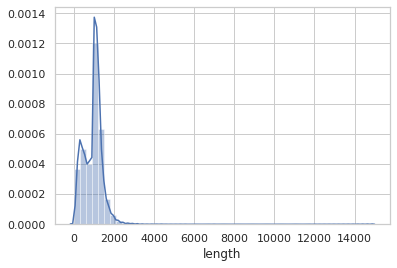

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = cleaned_proms_fiveUTR.copy()
graph['length'] = (graph.start - graph.stop).abs()
#graph.sort_values('length',ascending=True)

sns.set(color_codes=True)
sns.set_style("whitegrid")
dist_plot = graph['length']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()